In [5]:
import torch
from torch.func import jacrev, functional_call, vmap
import numpy as np
from pyDOE import lhs
from lm_train.network import DNN
from lm_train.training_module import training_LM
import matplotlib.pyplot as plt

In [6]:
def model_u(data, params):
    return functional_call(model, params, (data, )).squeeze()


def exact(data):
    """The exact solution"""
    x = data[..., 0]
    y = data[..., 1]
    return torch.sin(np.pi * x) * torch.sin(np.pi * y)


def force(data):
    """The force function."""
    x = data[..., 0]
    y = data[..., 1]
    return -2 * np.pi**2 * torch.sin(np.pi * x) * torch.sin(np.pi * y)


def generate2dRandomPoints(domainPoints, boundaryPoints, start=0., end=1.):
    """Generate 2d random points given start and end point."""
    data_d = torch.tensor(lhs(2, domainPoints))
    data_b = torch.empty((4 * int(boundaryPoints / 4), 2))
    n_edge = int(boundaryPoints / 4)
    sample_b = torch.tensor(lhs(1, boundaryPoints)).flatten()
    ones = torch.ones(n_edge)
    data_b[0:n_edge] = torch.column_stack((sample_b[0:n_edge], 0 * ones))
    data_b[n_edge:2 * n_edge] = torch.column_stack(
        (0 * ones, sample_b[n_edge:2 * n_edge]))
    data_b[2 * n_edge:3 * n_edge] = torch.column_stack(
        (ones, sample_b[2 * n_edge:3 * n_edge]))
    data_b[3 * n_edge:4 * n_edge] = torch.column_stack(
        (sample_b[3 * n_edge:], ones))

    # rescale the data
    data_d = (end - start) * data_d + start
    data_b = (end - start) * data_b + start
    return data_d, data_b

Solve the problem

$$\Delta u = f \text{ in } D$$

$$ u = g \text{ on } \partial D$$

where $f(x) = -2 \pi^2 \sin(\pi x) \sin(\pi y)$, $g(x) = \sin(\pi x) \sin(\pi y)$, and $D = \{(x, y) \in \mathbb{R}^2 : 0 < x < 1, 0 < y < 1\}$. 

In [7]:
def loss_residual(params, *args, **kwargs):
    "laplace u = f"
    data, force_value, = args
    grad_f = (jacrev(jacrev(model_u)))(data, params).squeeze()
    laplacian = torch.sum(torch.diagonal(grad_f))
    assert laplacian.shape == force_value.shape, 'The shape of laplacian and force_value should match'
    loss_d = laplacian - force_value
    return loss_d


def loss_target(params, *args, **kwargs):
    "General target loss"
    data, target, = args
    output = model_u(data, params)
    assert output.shape == target.shape, 'The shape of output and target should match'
    loss_b = output - target
    return loss_b

In [8]:
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers = [2, 100, 1]
n_points_d = 1000
n_points_b = 100
n_epoch = 1000
model = DNN(layers).to(device)
params = dict(model.named_parameters())
for p in params.values():
    p.requires_grad = False
data_d, data_b = generate2dRandomPoints(n_points_d, n_points_b)
data_d = data_d.to(device)
data_b = data_b.to(device)
force_value = force(data_d).to(device)
target = torch.zeros(n_points_b).to(device)

In [9]:
losses = [loss_residual, loss_target]
inputs = [[
    data_d,
    force_value,
], [
    data_b,
    target,
]]
kwargs = [{} for _ in range(len(losses))]
args = tuple(zip(losses, inputs, kwargs))

In [10]:
params, lossval_all, loss_running, lossval_test = training_LM(params,
                                                              device,
                                                              args,
                                                              steps=n_epoch)

Step: 100. loss: 3.0498e-04. mu: 3.6024e-13.
Step: 200. loss: 2.0407e-14. mu: 3.4162e-14.
Step: 300. loss: 3.0690e-16. mu: 1.1663e-13.
Step: 400. loss: 3.0690e-16. mu: 6.6358e-14.
Step: 500. loss: 3.0690e-16. mu: 3.7757e-14.
Step: 600. loss: 3.0690e-16. mu: 2.1483e-14.
Step: 700. loss: 3.0690e-16. mu: 1.2224e-14.
Step: 800. loss: 3.0690e-16. mu: 4.1730e-14.
Step: 900. loss: 3.0690e-16. mu: 2.3744e-14.
Step: 1000. loss: 3.0690e-16. mu: 1.3510e-14.
training time: 16.268977880477905 (s).


In [11]:
# compare with Adam 
model_adam = DNN(layers).to(device)
params_adam = dict(model_adam.named_parameters())
model_adam_func = lambda data, params: functional_call(model_adam, params, (data, )).squeeze()
optimizer = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
n_epoch_adam = 50000

for epoch in range(n_epoch_adam):
    optimizer.zero_grad()
    
    # lapalace u = f
    laplace_u = vmap((((jacrev(jacrev(model_adam_func))))), (0, None))(data_d, params_adam).squeeze()
    laplacian = torch.sum(torch.diagonal(laplace_u, dim1=-2, dim2=-1), dim=-1)
    loss_d = laplacian.flatten() - force_value.flatten()
    
    # u = g on boundary
    output_b = model_adam(data_b)
    loss_b = output_b.flatten() - target.flatten()
    
    loss = torch.sum(loss_d**2)/len(data_d) + torch.sum(loss_b**2)/len(data_b)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10000 == 0:
        print(f'Epoch {epoch+1}, loss = {loss.item():.4e}')
    


Epoch 10000, loss = 4.8876e-04
Epoch 20000, loss = 4.1190e-05
Epoch 30000, loss = 3.8256e-05
Epoch 40000, loss = 1.8734e-05
Epoch 50000, loss = 1.8613e-05


In [12]:
# calculate the L_inf error
model = model.cpu()
model_adam = model_adam.cpu()
with torch.no_grad():
    data_d_test, data_b_test = generate2dRandomPoints(int(1e5), int(1e5))
    data_test = torch.row_stack((data_d_test, data_b_test))
    output = model(data_test).flatten()
    output_adam = model_adam(data_test).flatten()
    exact_u = exact(data_test).flatten()
    error = torch.linalg.norm(output - exact_u, float('inf'))
    error_adam = torch.linalg.norm(output_adam - exact_u, float('inf'))
    print(f'L_inf error of LM: {error.item():.4e}')
    print(f'L_inf error of Adam: {error_adam.item():.4e}')

L_inf error of LM: 1.1779e-07
L_inf error of Adam: 2.7007e-03


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


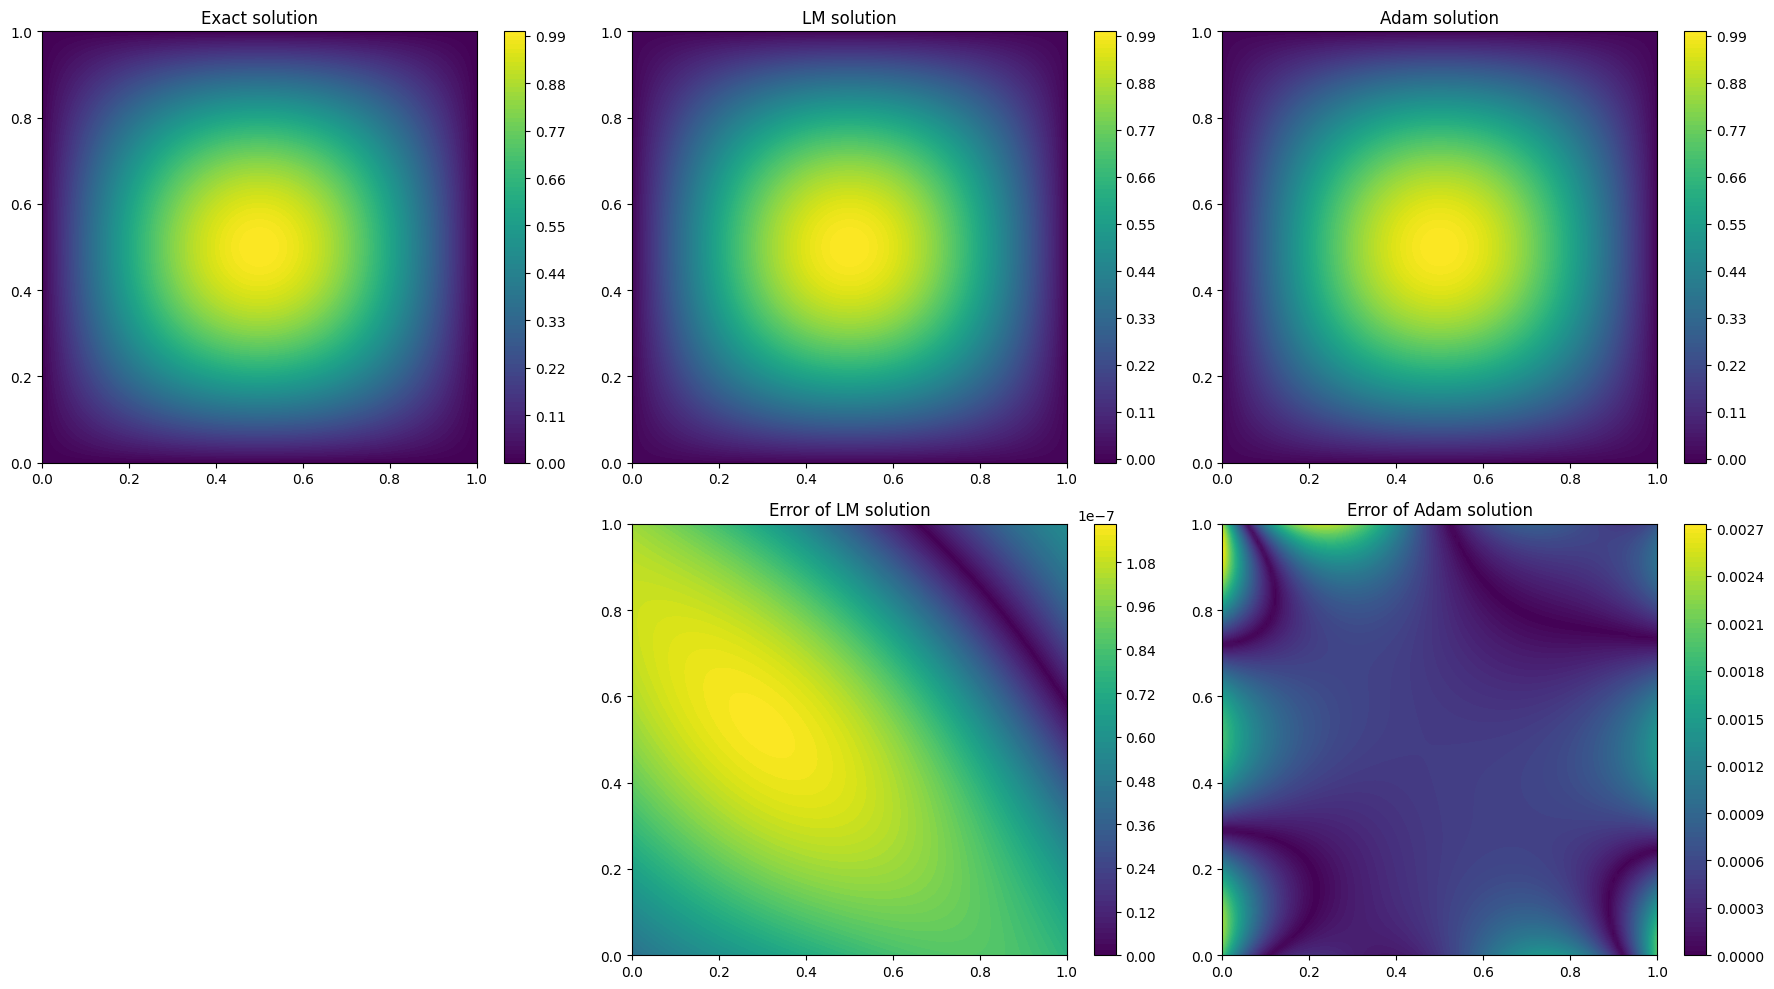

In [13]:
with torch.no_grad():
    x_mesh, y_mesh = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))
    data_plot = torch.column_stack((x_mesh.flatten(), y_mesh.flatten()))
    exact_plot = exact(data_plot).reshape(100, 100)
    output_plot = model(data_plot).reshape(100, 100)
    output_adam_plot = model_adam(data_plot).reshape(100, 100)
    error_plot = torch.abs(output_plot - exact_plot)
    error_adam_plot = torch.abs(output_adam_plot - exact_plot)
    
    # Plot exact solution
    c0 = ax[0, 0].contourf(x_mesh, y_mesh, exact_plot, 100, cmap='viridis')
    fig.colorbar(c0, ax=ax[0, 0])
    ax[0, 0].set_title('Exact solution')
    
    # Plot LM solution
    c1 = ax[0, 1].contourf(x_mesh, y_mesh, output_plot, 100, cmap='viridis')
    fig.colorbar(c1, ax=ax[0, 1])
    ax[0, 1].set_title('LM solution')
    
    # Plot Adam solution
    c2 = ax[0, 2].contourf(x_mesh, y_mesh, output_adam_plot, 100, cmap='viridis')
    fig.colorbar(c2, ax=ax[0, 2])
    ax[0, 2].set_title('Adam solution')
    
    # Plot error for LM solution
    c3 = ax[1, 1].contourf(x_mesh, y_mesh, error_plot, 100, cmap='viridis')
    fig.colorbar(c3, ax=ax[1, 1])
    ax[1, 1].set_title('Error of LM solution')
    
    # Plot error for Adam solution
    c4 = ax[1, 2].contourf(x_mesh, y_mesh, error_adam_plot, 100, cmap='viridis')
    fig.colorbar(c4, ax=ax[1, 2])
    ax[1, 2].set_title('Error of Adam solution')
    
    ax[1, 0].axis('off')
    
    plt.tight_layout()
    plt.savefig('img/2d_poisson.png', bbox_inches='tight')
    plt.show()